# Setup

 Import standard modules

In [1]:
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt

from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed

Find project root, append to path, and define wdir for data

In [2]:
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim"

Import project modules from src folder

In [3]:
from src import models
from src import features
from src import visualization as viz

## Load tides

Sutarkhali pressure data from 2019 collected by Rip Hale and Rachel Bain. Original data was sampled every 10 min. Data was cleaned, processed, and upscaled to 1 s using the OCE package (https://cran.r-project.org/web/packages/oce/) in R. Processed data is stored in `data/interim/` in the feather format.

`tides.feather` is 1 yr of data sampled every 1 s

`tides-debug.feather` is 1 inundation cycle sampled every 1 s

In [4]:
tides = features.load_tide(wdir, 'tides-debug.feather')

Downsample tide data

In [5]:
dt = 30  # seconds
tides = tides.iloc[0:-1:dt]

## Set model parameters

In [6]:
# Set grain parameters and settling velocity
grain_dia = 0.000035  # grain diameter (m)
grain_den = 2650 # grain density (kg/m^3)
settle_rate = models.stokes_settling(grain_dia=grain_dia, grain_den=grain_den)  # settling rate determined by Stokes' Law

# Set basic model parameters
bound_conc = 0.8  # boundary concentration (g/L or kg/m^3)
bulk_dens = 1100  # dry bulk density of sediment (kg/m^3)
min_depth = 0.001  # Minimum depth required before integrating. Used for stability at very shallow depths. (m)
init_elev = 0  # initial elevation (m)
years = 1  # total run length (yr)
slr = 0.005  # yearly rate of sea level rise (m)

# Sensitivity Analysis

In [7]:
class ModelClass:
    def __init__(self, tides_ts, settle_rate, bulk_dens, bound_conc, init_elev, years=1, slr=0, verbose=False):
        self.tides_ts = tides_ts
        self.settle_rate = settle_rate
        self.bulk_dens = bulk_dens
        self.bound_conc = bound_conc
        self.init_elev = init_elev
        self.years = years
        self.slr = slr
        self.verbose = verbose

def parallel_parser(params):
    model_tides, model_results = models.run_model(tides_ts=params.tides_ts, settle_rate=params.settle_rate, bulk_dens=params.bulk_dens,
                     bound_conc=params.bound_conc, init_elev=params.init_elev, years=params.years, slr=params.slr,
                     verbose=params.verbose)
    return model_results.y[1][-1]

from SALib.sample import saltelli
problem = {
    'num_vars': 3,
    'names': ['bound_conc', 'settle_rate', 'bulk_dens'],
    'bounds': [[0.01, 2.0],
               [0.00001, 0.01],
               [800, 1300]]
}
param_values = saltelli.sample(problem, 1000)

mods = []
for i, X in enumerate(param_values):
    bound_conc = X[0]
    settle_rate = X[1]
    bulk_dens = X[2]
    mod = ModelClass(tides_ts=tides, settle_rate=settle_rate,
                                      bulk_dens=bulk_dens, bound_conc=bound_conc,
                                      init_elev=init_elev, years=years, slr=slr, verbose=False)
    mods.append(mod)

from joblib import Parallel, delayed
results = Parallel(n_jobs=50)(delayed(parallel_parser)(mod) for mod in mods)

In [8]:
class ModelClass:
    def __init__(self, tides_ts, settle_rate, bulk_dens, bound_conc, init_elev, years=1, slr=0, verbose=False):
        self.tides_ts = tides_ts
        self.settle_rate = settle_rate
        self.bulk_dens = bulk_dens
        self.bound_conc = bound_conc
        self.init_elev = init_elev
        self.years = years
        self.slr = slr
        self.verbose = verbose

def parallel_parser(params):
    model_tides, model_results = models.run_model(tides_ts=params.tides_ts, settle_rate=params.settle_rate, bulk_dens=params.bulk_dens,
                     bound_conc=params.bound_conc, init_elev=params.init_elev, years=params.years, slr=params.slr,
                     verbose=params.verbose)
    return model_results.y[1][-1]

In [9]:
problem = {
    'num_vars': 3,
    'names': ['bound_conc', 'settle_rate', 'bulk_dens'],
    'bounds': [[0.01, 2.0],
               [0.00001, 0.01],
               [800, 1300]]
}
param_values = saltelli.sample(problem, 1000)

mods = []
for i, X in enumerate(param_values):
    bound_conc = X[0]
    settle_rate = X[1]
    bulk_dens = X[2]
    mod = ModelClass(tides_ts=tides, settle_rate=settle_rate,
                                      bulk_dens=bulk_dens, bound_conc=bound_conc,
                                      init_elev=init_elev, years=years, slr=slr, verbose=False)
    mods.append(mod)

In [10]:
results = Parallel(n_jobs=50)(delayed(parallel_parser)(mod) for mod in mods)
results = np.ravel(results)

In [11]:
print('bound_conc: {:.4f} +- {:.4f}'.format(Si['ST'][0], Si['ST_conf'][0]))
print('settle_rate: {:.4f} +- {:.4f}'.format(Si['ST'][1], Si['ST_conf'][1]))
print('bulk_dens: {:.4f} +- {:.4f}'.format(Si['ST'][2], Si['ST_conf'][2]))

NameError: name 'Si' is not defined

In [ ]:
print("x1-x2:", Si['S2'][0,1])
print("x1-x3:", Si['S2'][0,2])
print("x2-x3:", Si['S2'][1,2])

In [12]:
all_bound_conc = np.ravel([i[0] for i in param_values])
all_settle_rate = np.ravel([i[1] for i in param_values])
all_bulk_dens = np.ravel([i[2] for i in param_values])

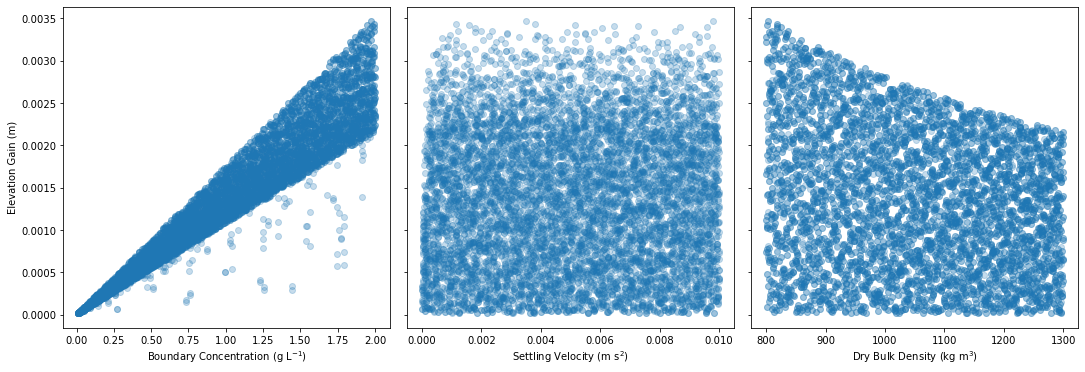

In [13]:
fig, axs = plt.subplots(1, 3)
fig.set_figheight(5)
fig.set_figwidth(15)

axs[0].scatter(all_bound_conc, results, alpha=0.25)
axs[1].scatter(all_settle_rate, results, alpha=0.25)
axs[2].scatter(all_bulk_dens, results, alpha=0.25)
plt.setp(axs[1].get_yticklabels(), visible=False);
plt.setp(axs[2].get_yticklabels(), visible=False);
plt.tight_layout()
axs[0].set_ylabel('Elevation Gain (m)');
axs[0].set_xlabel('Boundary Concentration (g L$^{-1}$)');
axs[1].set_xlabel('Settling Velocity (m s$^{2}$)');
axs[2].set_xlabel('Dry Bulk Density (kg m$^{3}$)');